# 간단한 모델 생성
- XGB
- LGBM
- 'X,Y + 버스 + 지하철' 전처리된 데이터 사용
- 전처리 안 된 feature는 일단 삭제

In [2]:
!pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/f2/3d/4f152cf694aec100ab63b4a5547f2dbfbea59ab39d9375c89bed9775e47d/lightgbm-4.4.0-py3-none-manylinux_2_28_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 13.7 MB/s eta 0:00:0000:0100:01


In [90]:
!pip install joblib

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import gc

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

import joblib

# 맥에서 글씨 깨짐 방지
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

# Data Load

In [202]:
df = pd.read_csv('/root/home_predict/dataset/22_subway_line.csv')

/tmp/ipykernel_559971/636612162.py:1: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/root/home_predict/dataset/22_subway_line.csv')


## 결측치 제거

In [3]:
pd.set_option('display.max_rows', None)
df.isnull().sum()

시군구                           0
번지                          227
본번                           75
부번                           75
아파트명                          0
전용면적                          0
계약년월                          0
계약일                           0
층                             0
건축년도                          0
도로명                           0
해제사유발생일                 1121899
등기신청일자                        0
거래유형                          0
중개사소재지                        0
k-단지분류(아파트,주상복합등등)       877273
k-전화번호                   876850
k-팩스번호                   879348
단지소개기존clob              1058958
k-세대타입(분양형태)             876125
k-관리방식                   876125
k-복도유형                   876454
k-난방방식                   876125
k-전체동수                   877207
k-전체세대수                  876125
k-건설사(시공사)                    0
k-시행사                    877834
k-사용검사일-사용승인일            876259
k-연면적                    876125
k-주거전용면적                 876170
k-관리비부과면적                876125
k-전용면적별세

In [4]:
# Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('결측치가 100만개 이하인 변수들 :', list(df.columns[df.isnull().sum() <= 1000000])) # 남겨질 변수들은 아래와 같습니다.
print('결측치가 100만개 이상인 변수들 : ', list(df.columns[df.isnull().sum() >= 1000000]))

결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60이하)', 'k-전용면적별세대현황(60~85이하)', 'k-85~135이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '시군구 번지', '좌표X,좌표Y', '가장 가까운 거리', 'index', '역사_ID', '역사명', '호선', '위도', '경도', '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리', '가장 가까운 버스 정류장 index', '가장 가까운 버스 정류장 노드 ID', '가장 가까운 버스 정류소번호', '가장 가까운 버스 정류소명', '가장 가까운 버스 정류소 타입', '가장 가까운 버스 정류장 X좌표', '가장 가까운 버스 정류장 Y좌표', '인근 버스 정류장 개수', '계약년', '계약월', 'GDP', '한국은행 기준금리', '기대 인플레이션', '지가지수', '아파트 인허가', '미분양', '거래량', '건설사 랭킹', '구', '동', '구별 지가지수', '공시지가 평균', '매수우위지수', '건물나이', '30년이상50년이하', '구매력지수', '거래활발지수', '매매가격 지수 증감률', '매매

In [203]:
df.drop(['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호',
         'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수',
         'k-사용검사일-사용승인일', 'k-관리비부과면적', 'k-전용면적별세대현황(60이하)', 'k-전용면적별세대현황(60~85이하)',
         'k-85~135이하', 'k-135초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태',
         '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일'], axis=1, inplace=True)

In [204]:
df.drop(['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-관리방식', 'k-건설사(시공사)', 'k-시행사', 'k-연면적', 'k-주거전용면적',
         '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '시군구 번지', '좌표X,좌표Y', 'index', '역사_ID', '역사명', '위도', '경도',
         '가장 가까운 버스 정류장 index', '가장 가까운 버스 정류장 노드 ID', '가장 가까운 버스 정류소번호', '가장 가까운 버스 정류소명',
         '가장 가까운 버스 정류소 타입', '가장 가까운 버스 정류장 X좌표', '가장 가까운 버스 정류장 Y좌표', '동', 
         ], axis=1, inplace=True)

In [49]:
df.columns

Index(['전용면적', '계약년월', '계약일', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test',
       '가장 가까운 거리', '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', '계약년',
       '계약월', 'GDP', '한국은행 기준금리', '기대 인플레이션', '지가지수', '아파트 인허가', '미분양', '거래량',
       '건설사 랭킹', '구별 지가지수', '공시지가 평균', '매수우위지수', '건물나이', '30년이상50년이하', '구매력지수',
       '거래활발지수', '매매가격 지수 증감률', '매매 대비 전세가격 비율', '아파트 카테고리', '지하철 카테고리'],
      dtype='object')

## 이상치 확인

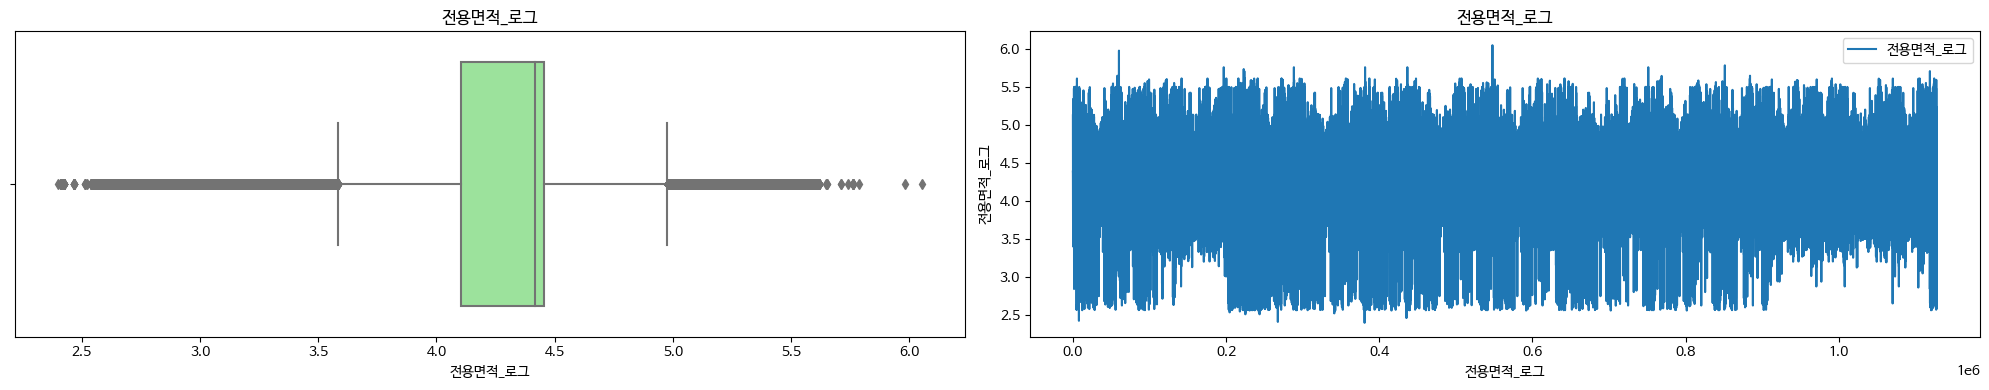

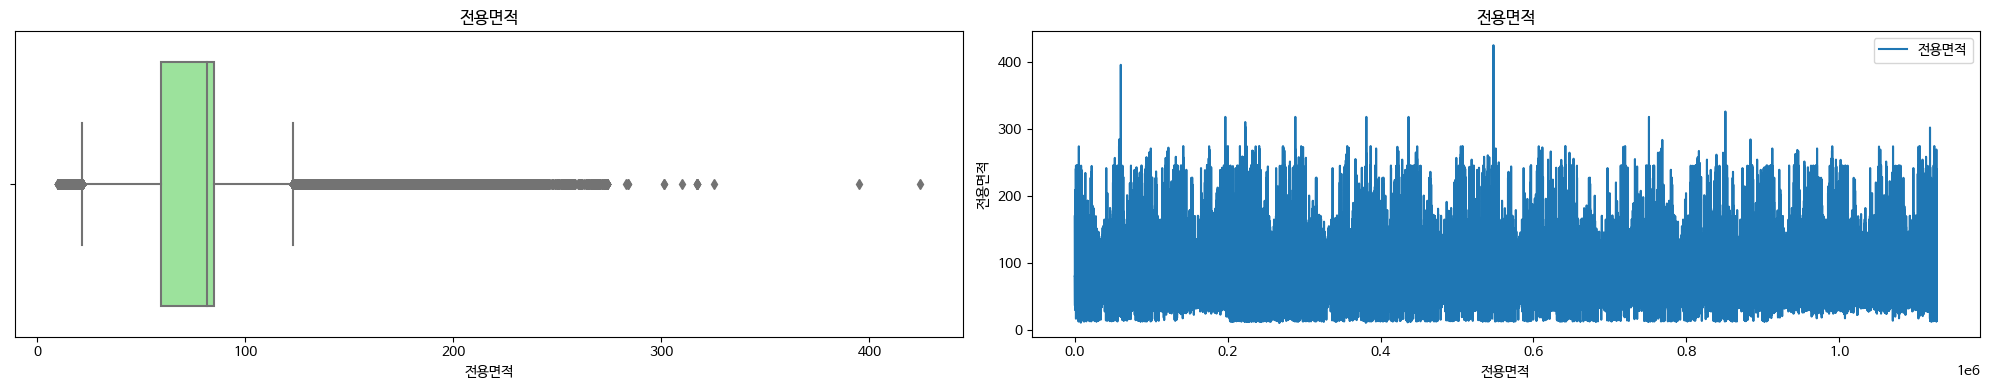

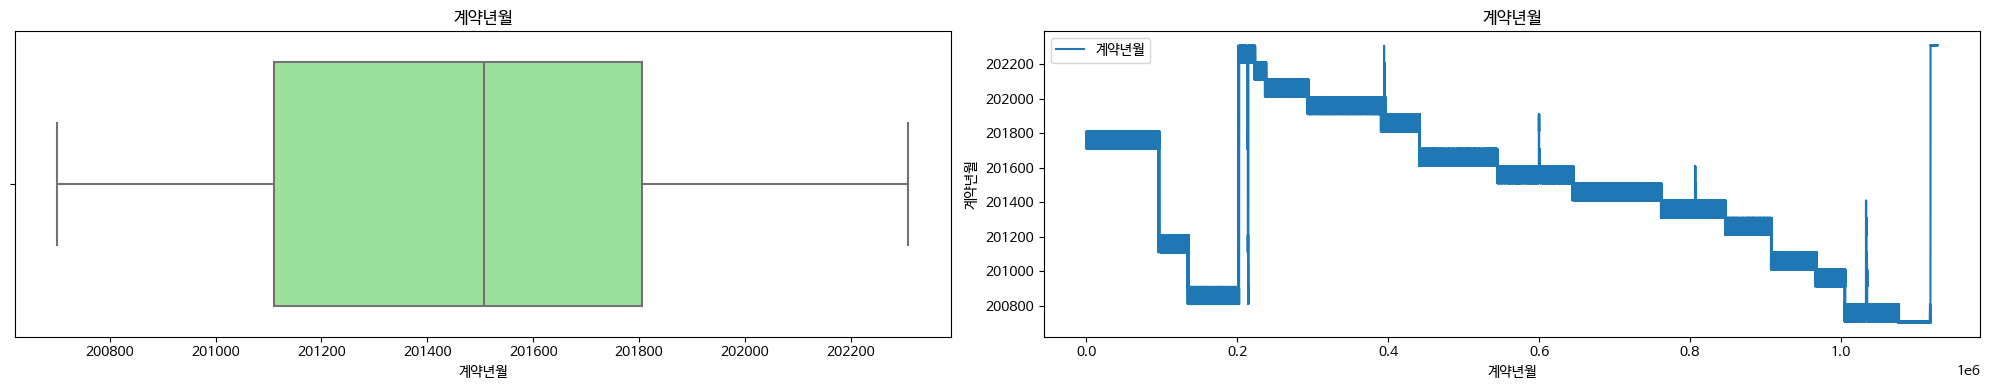

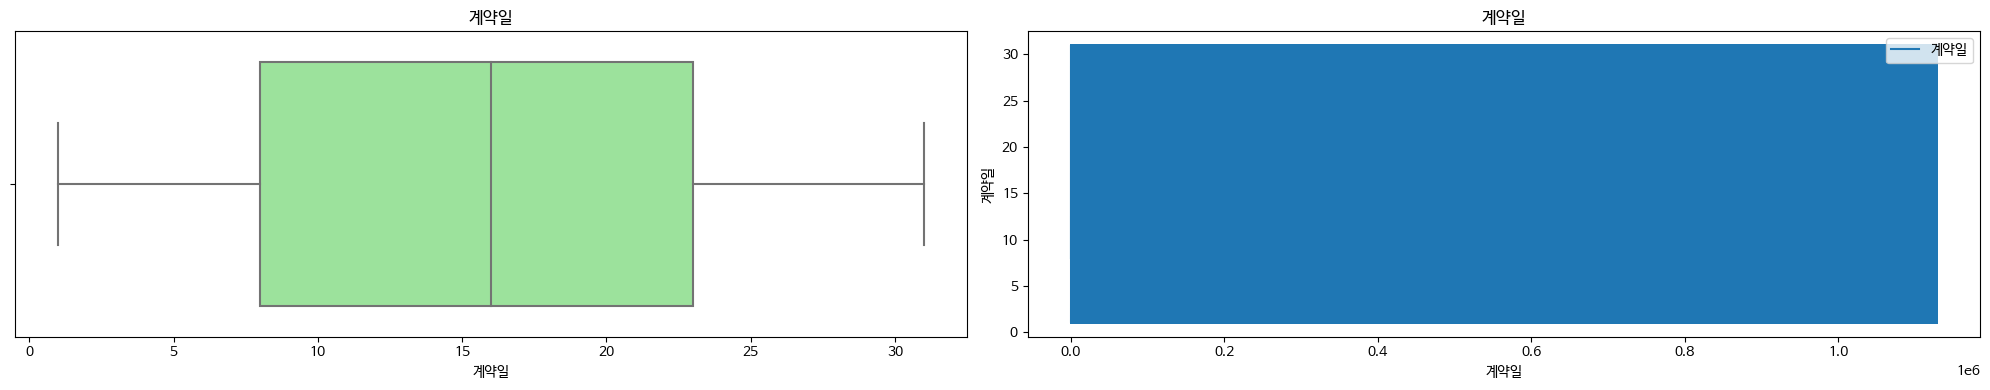

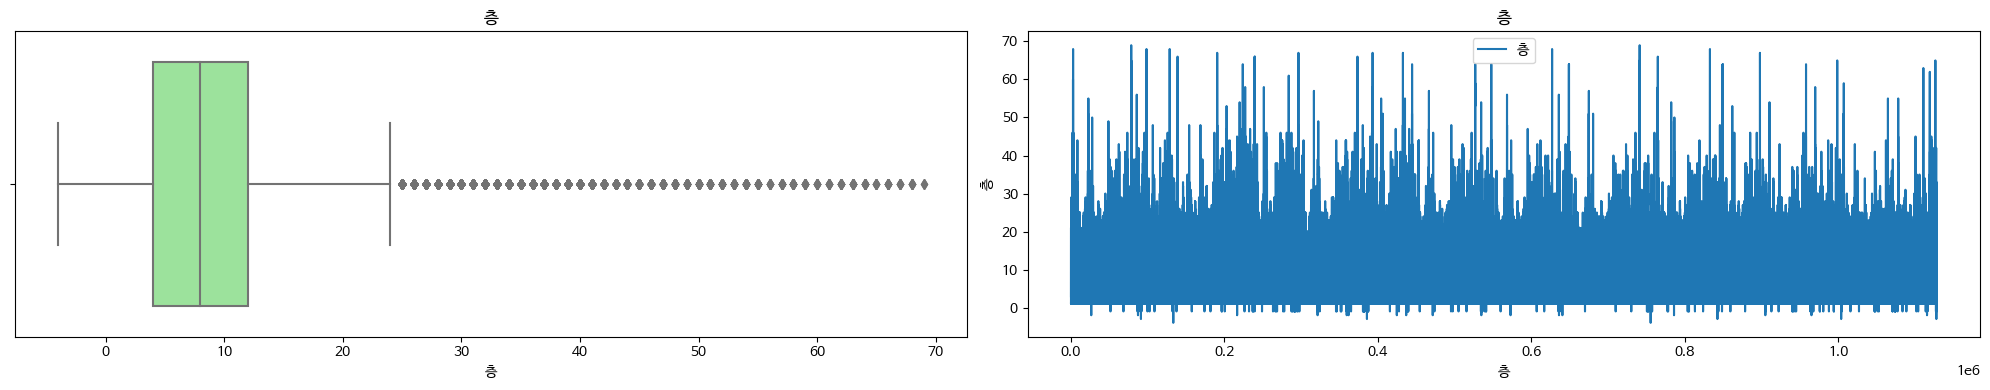

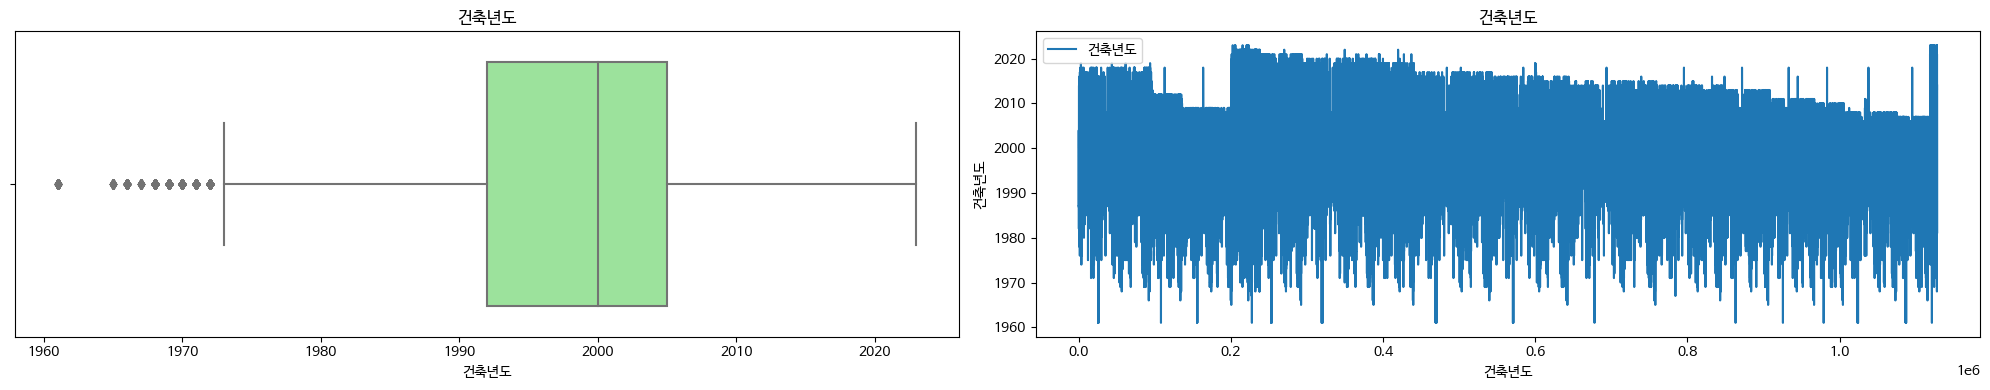

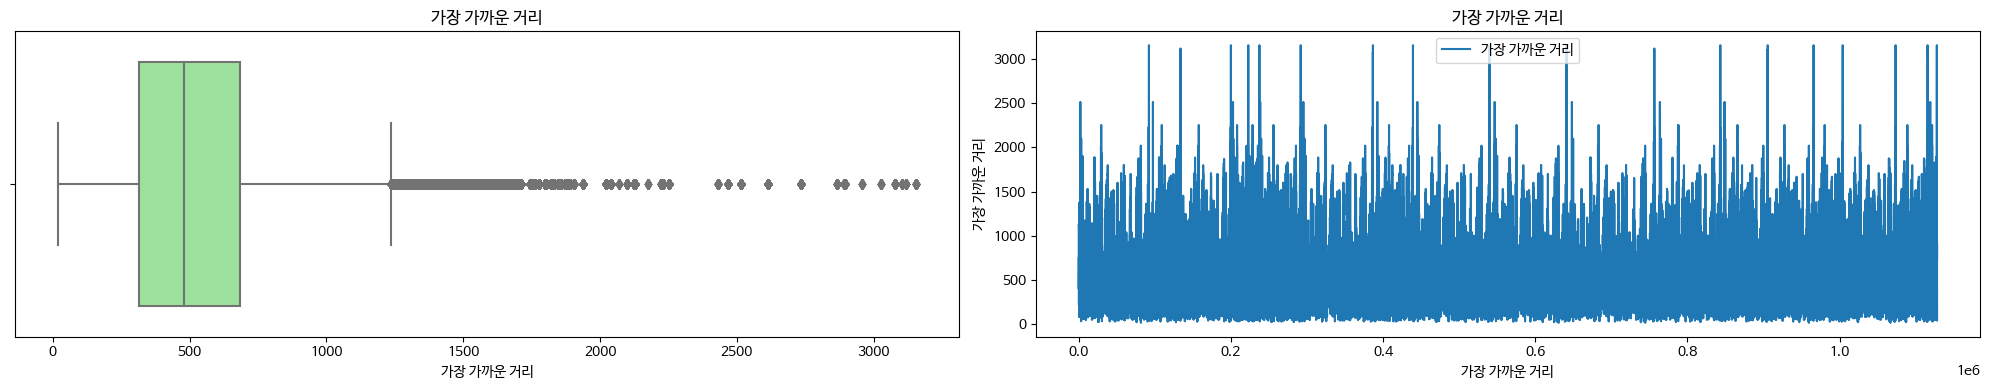

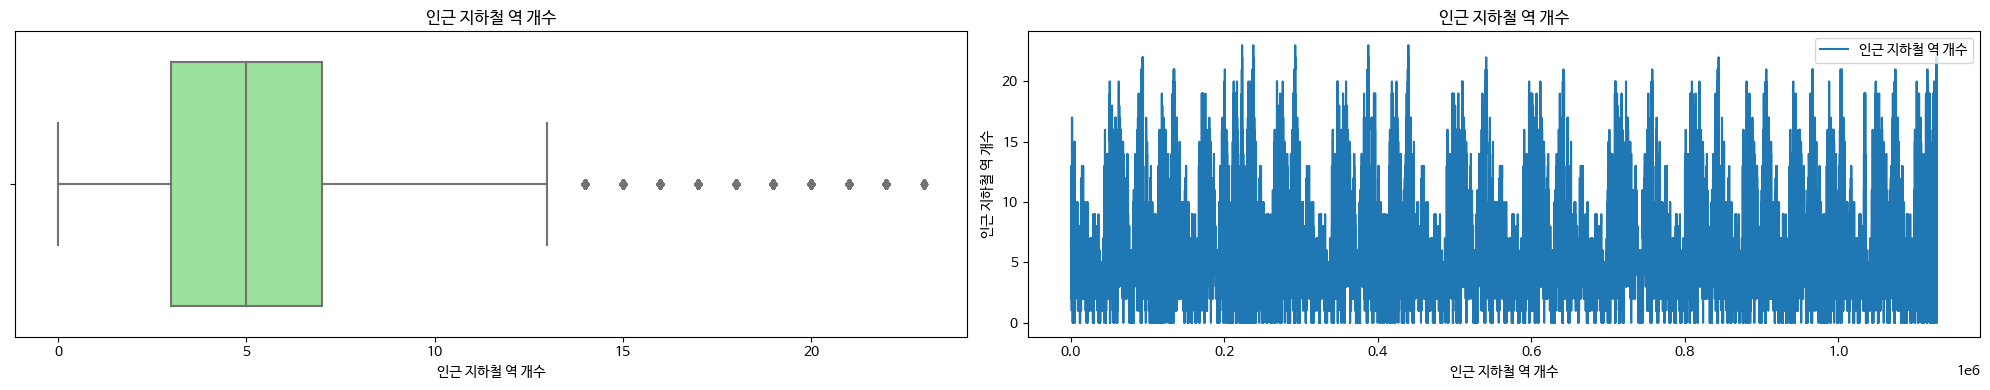

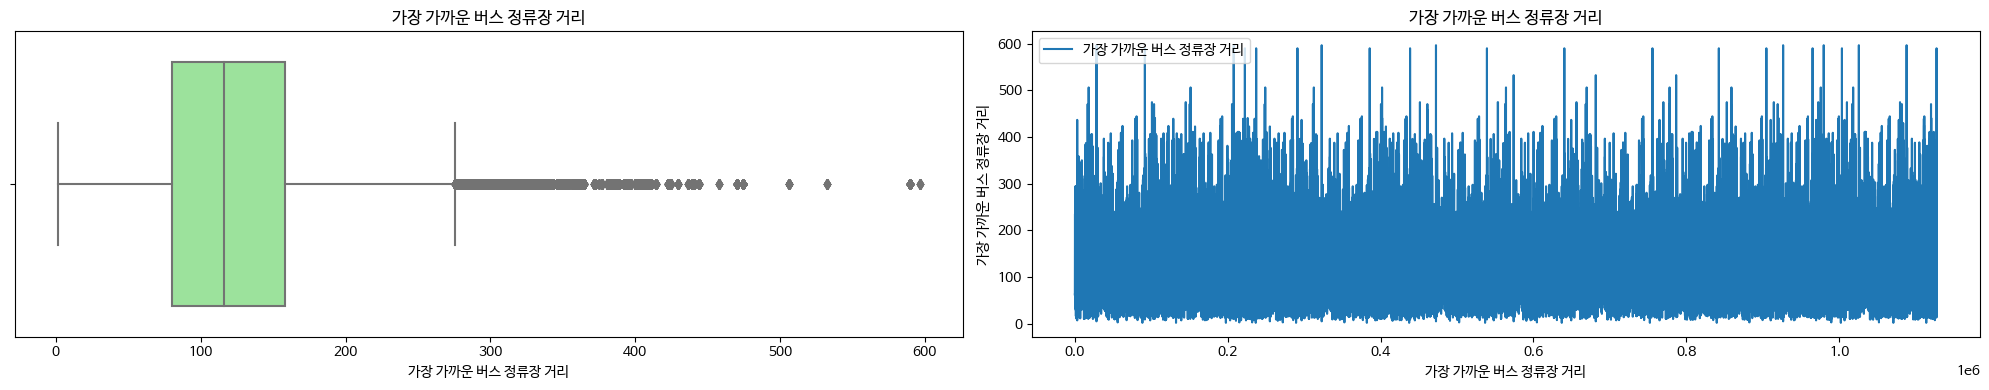

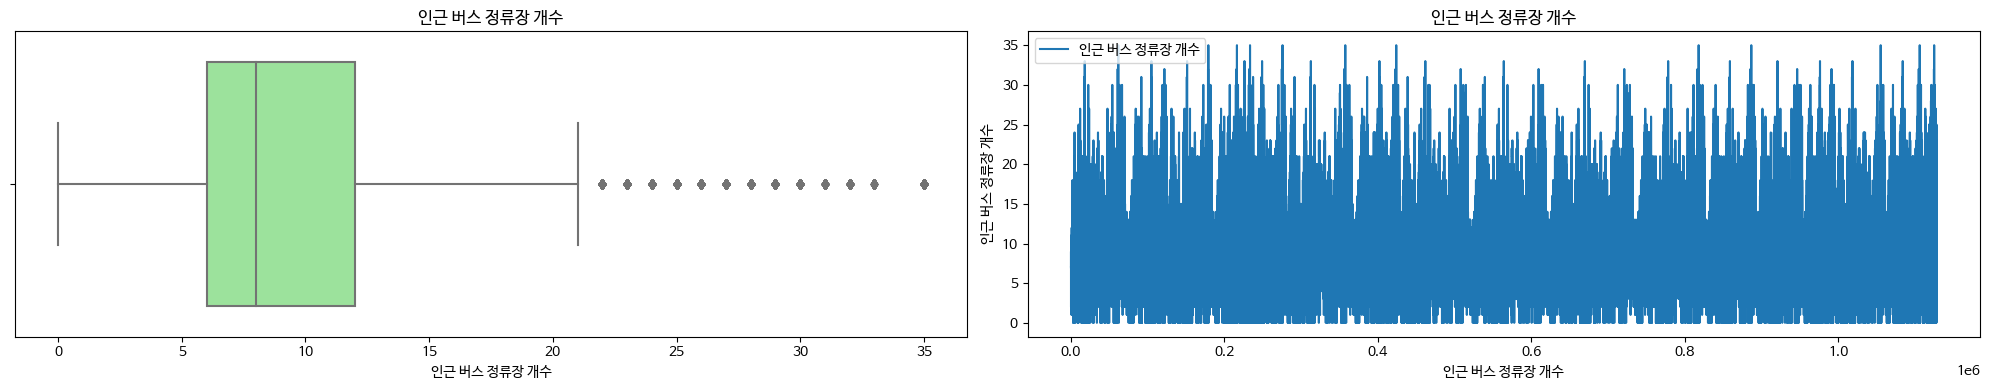

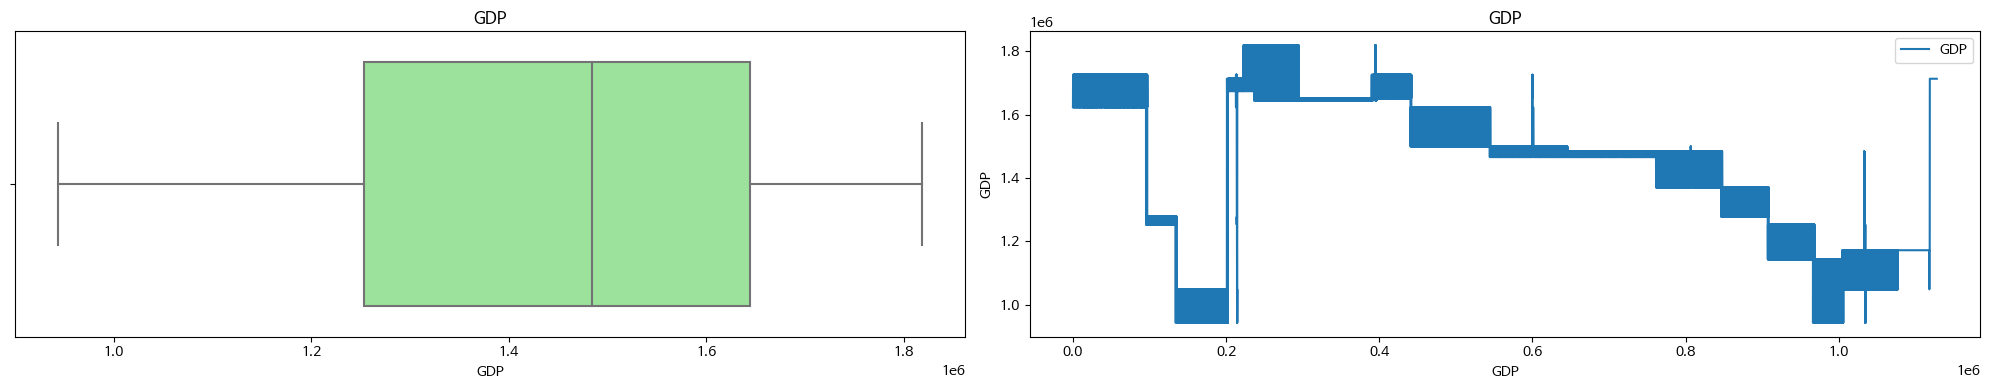

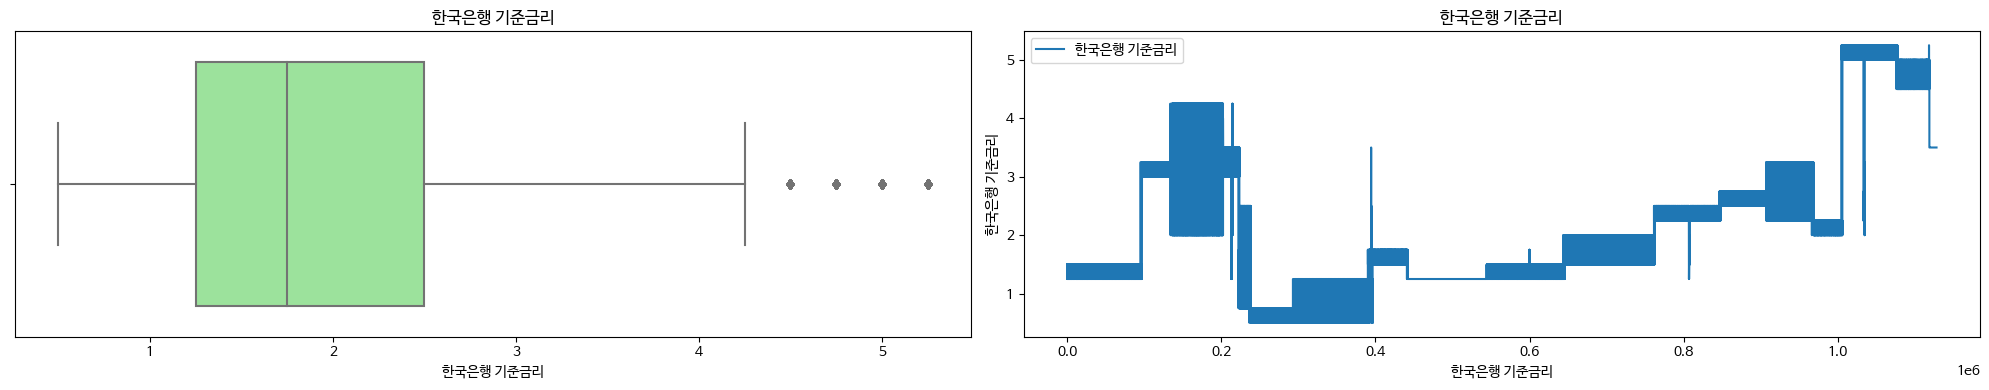

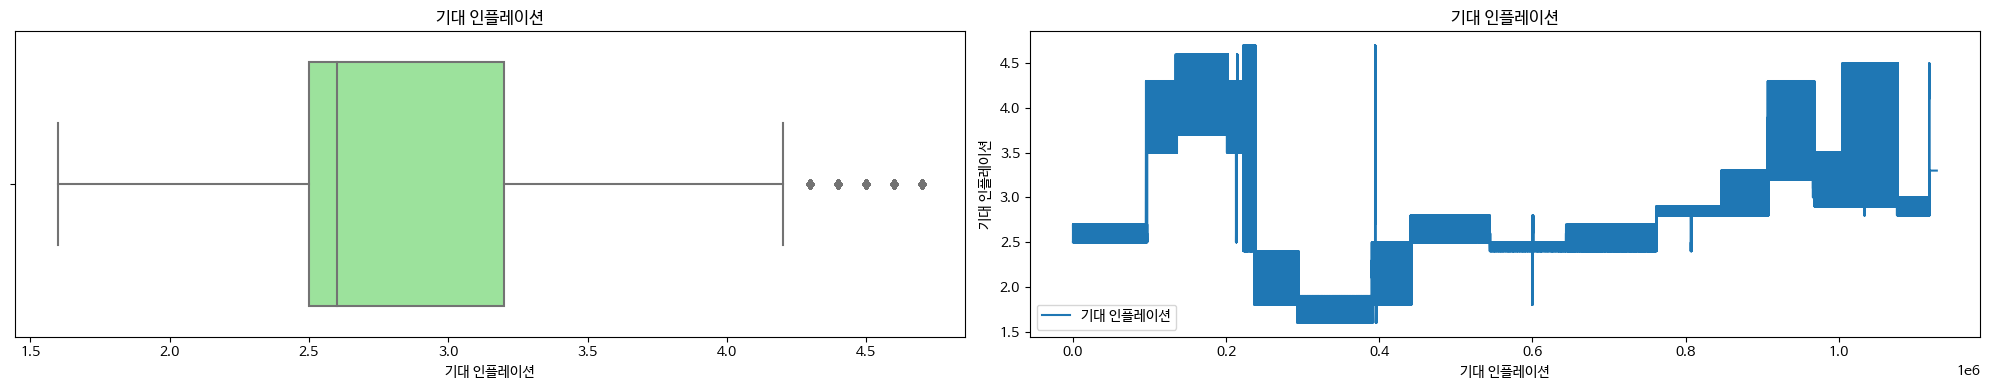

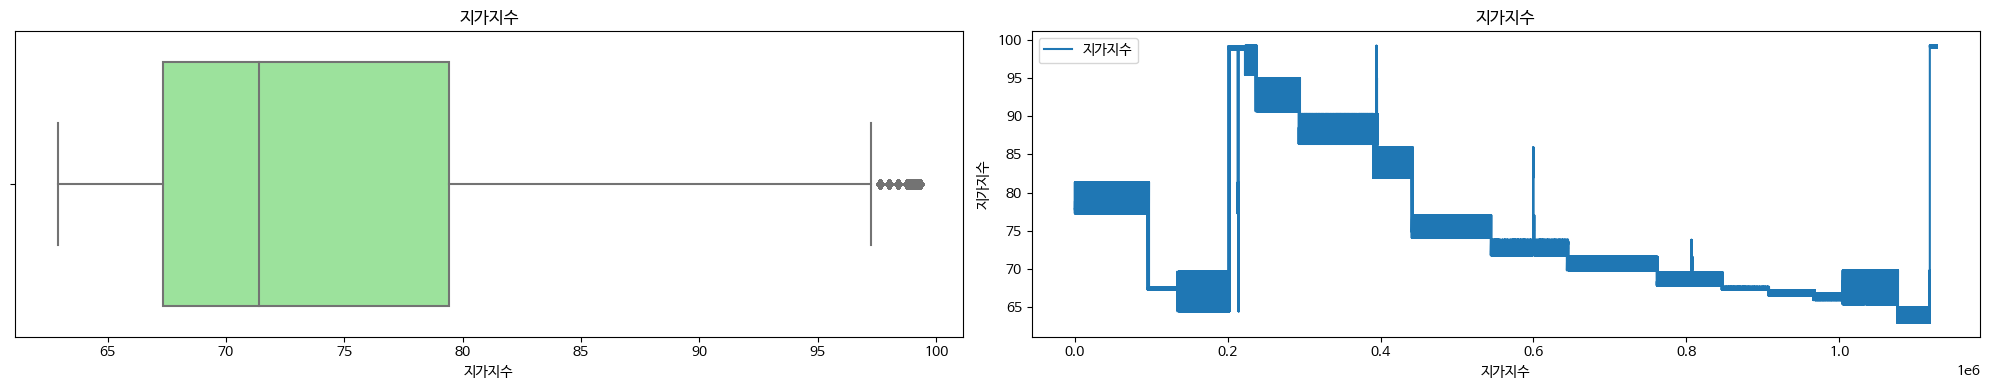

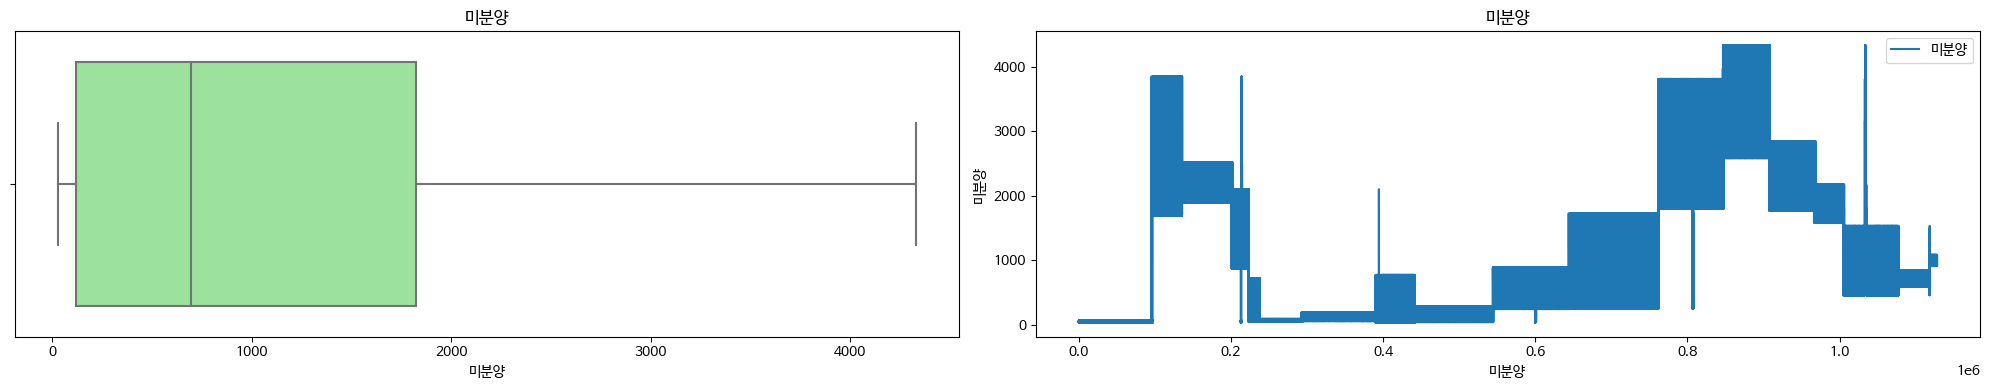

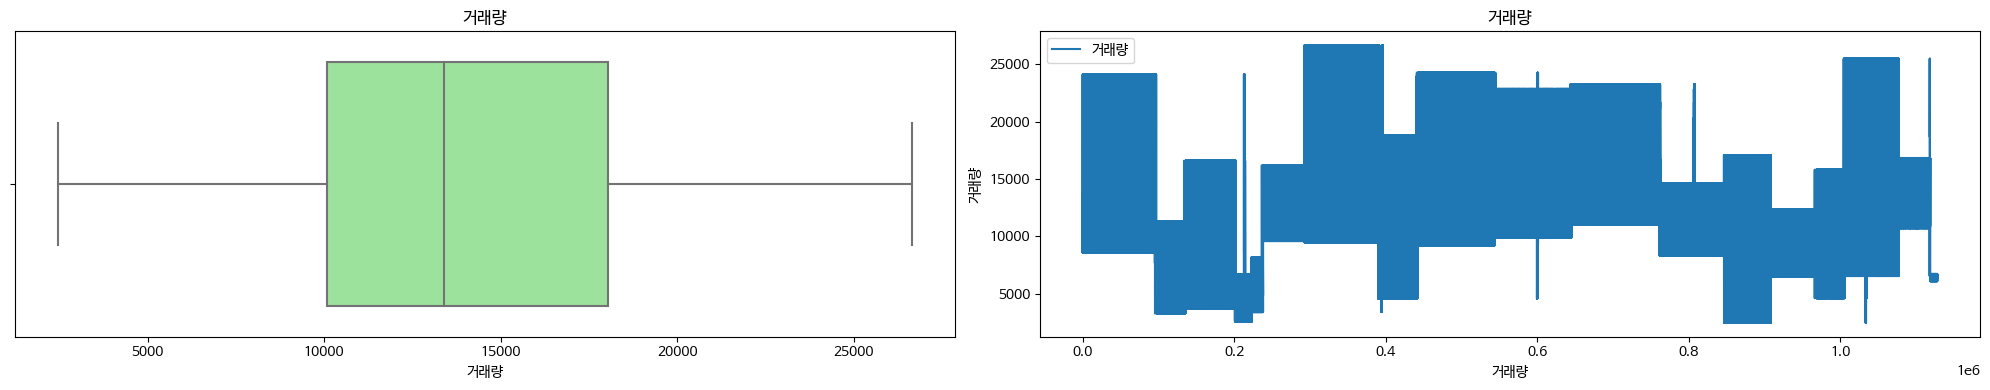

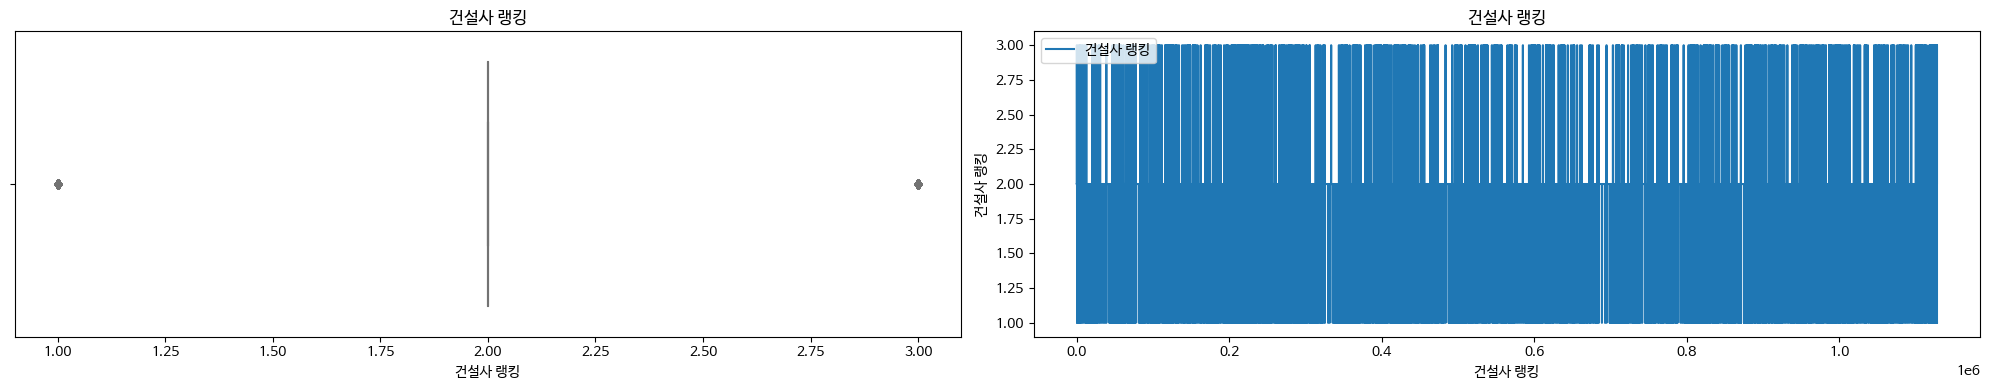

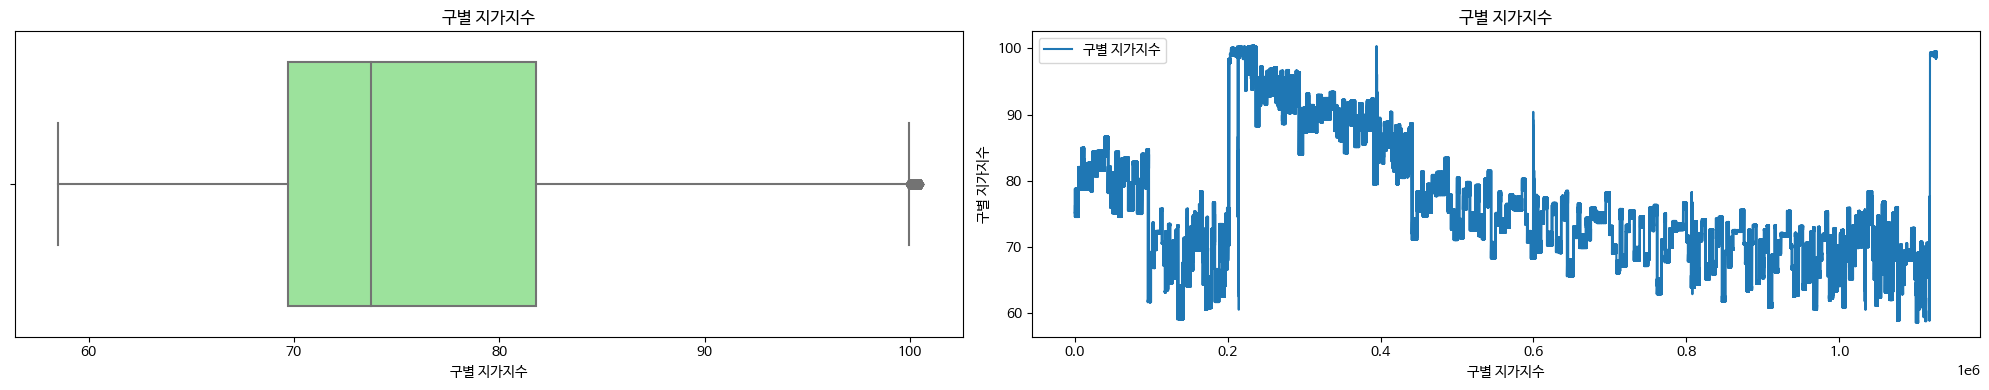

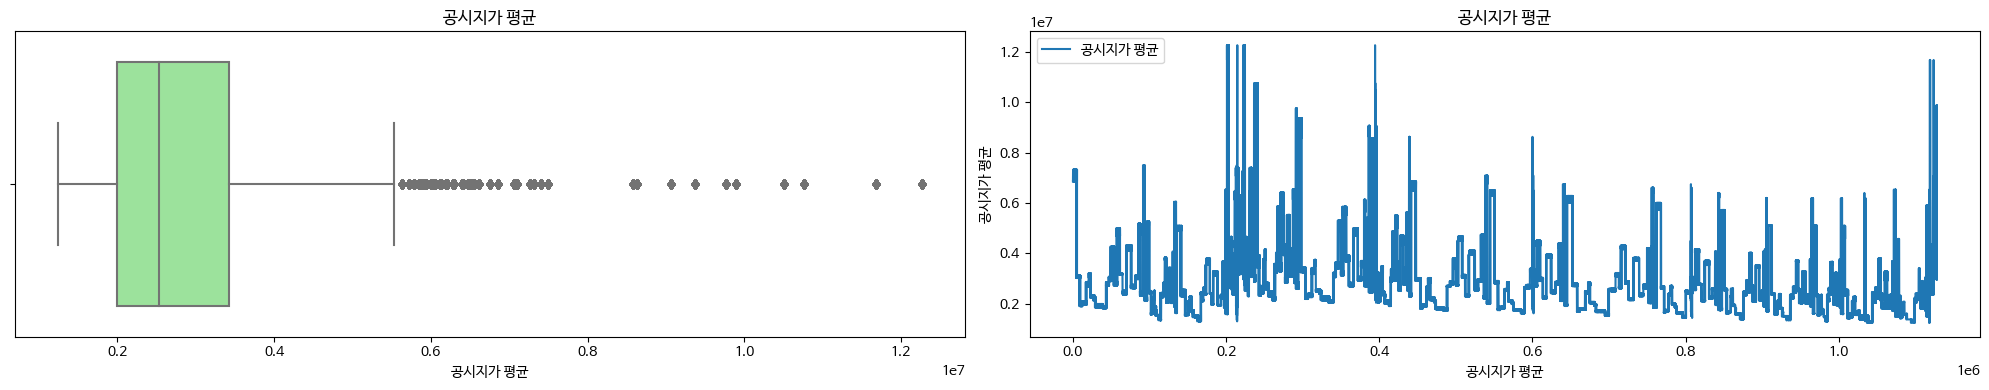

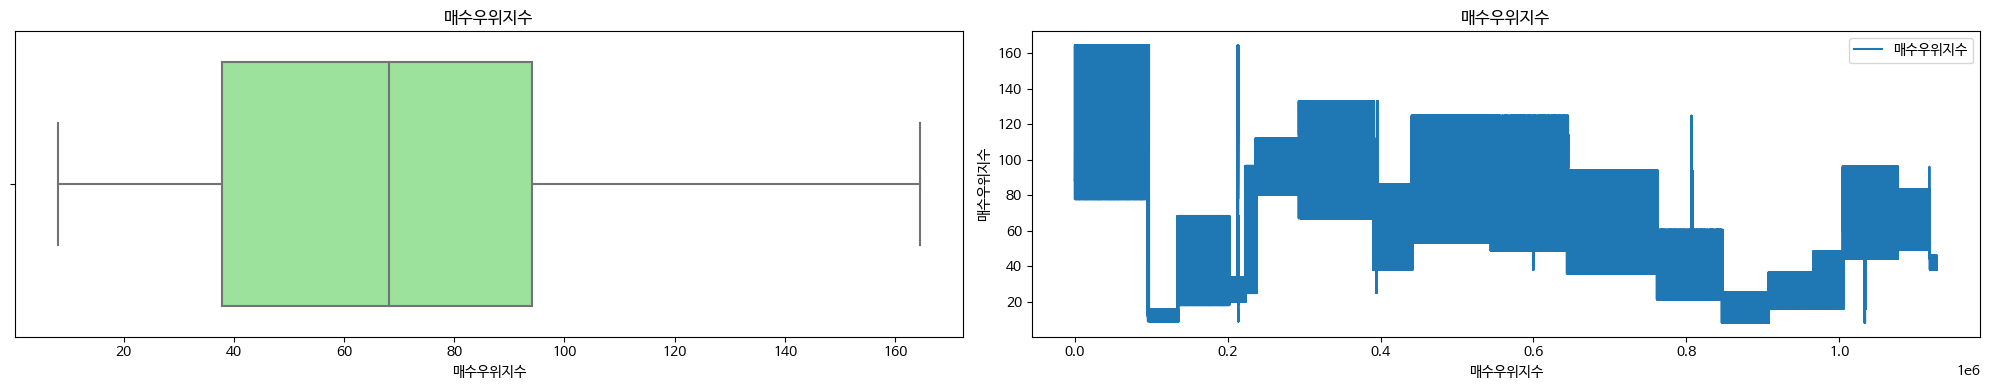

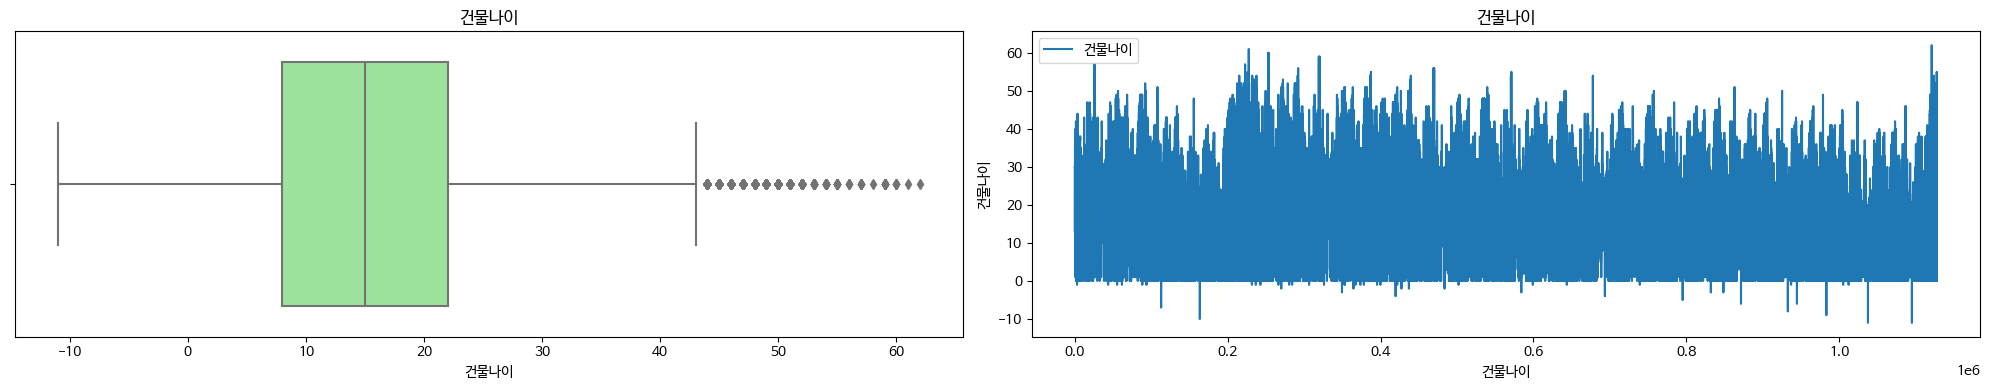

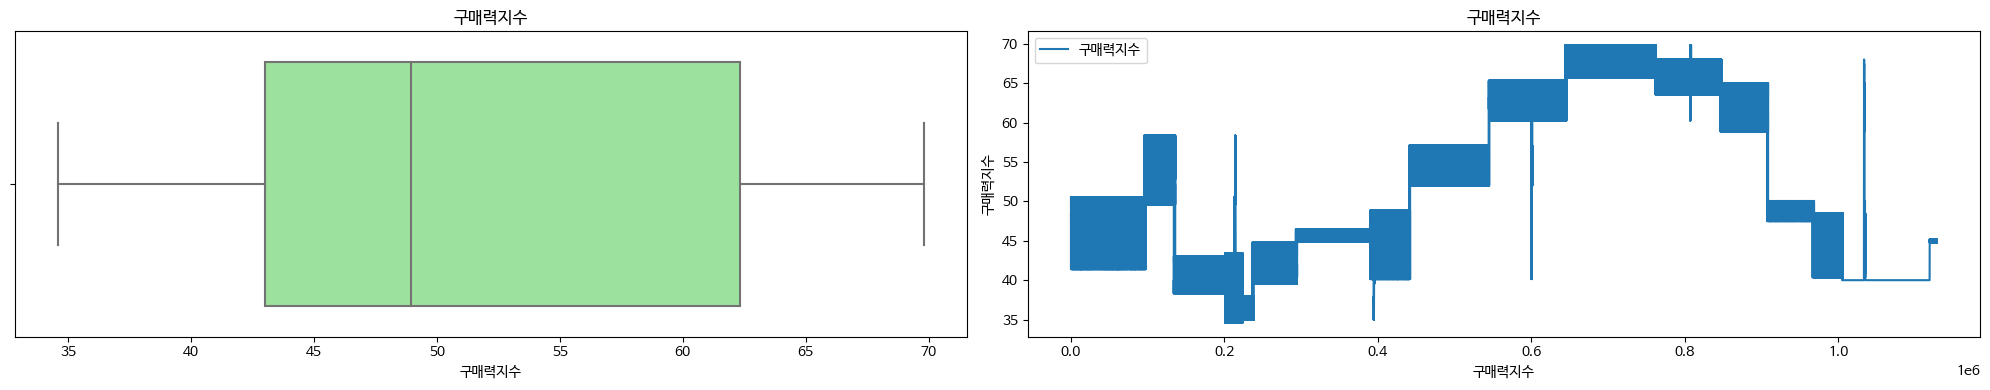

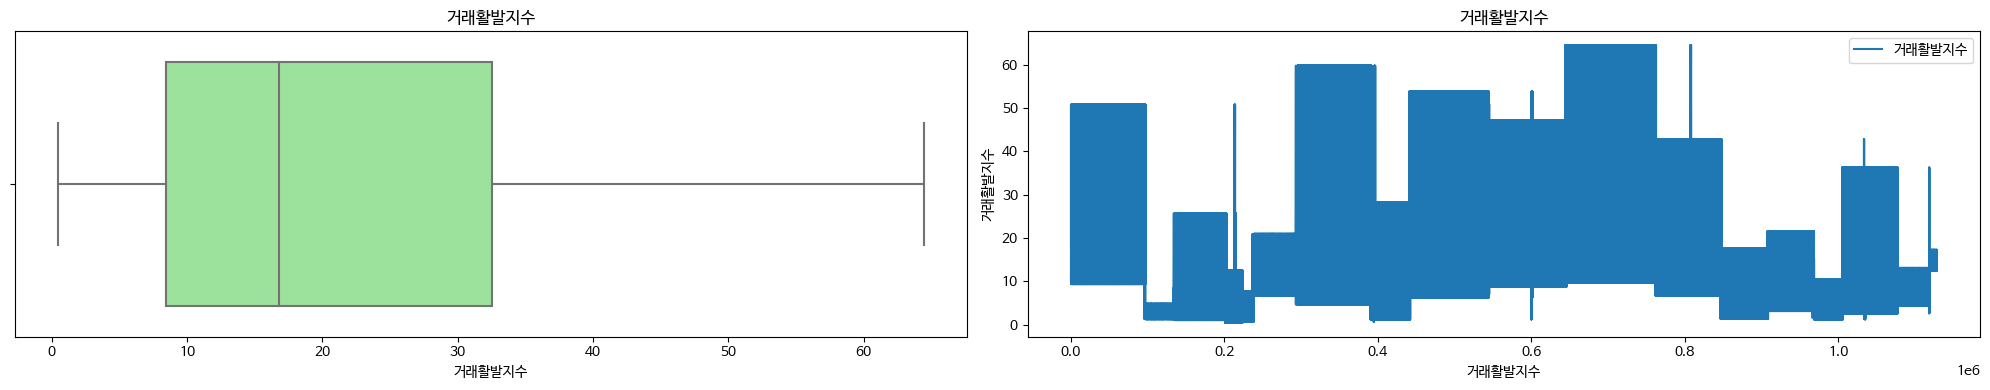

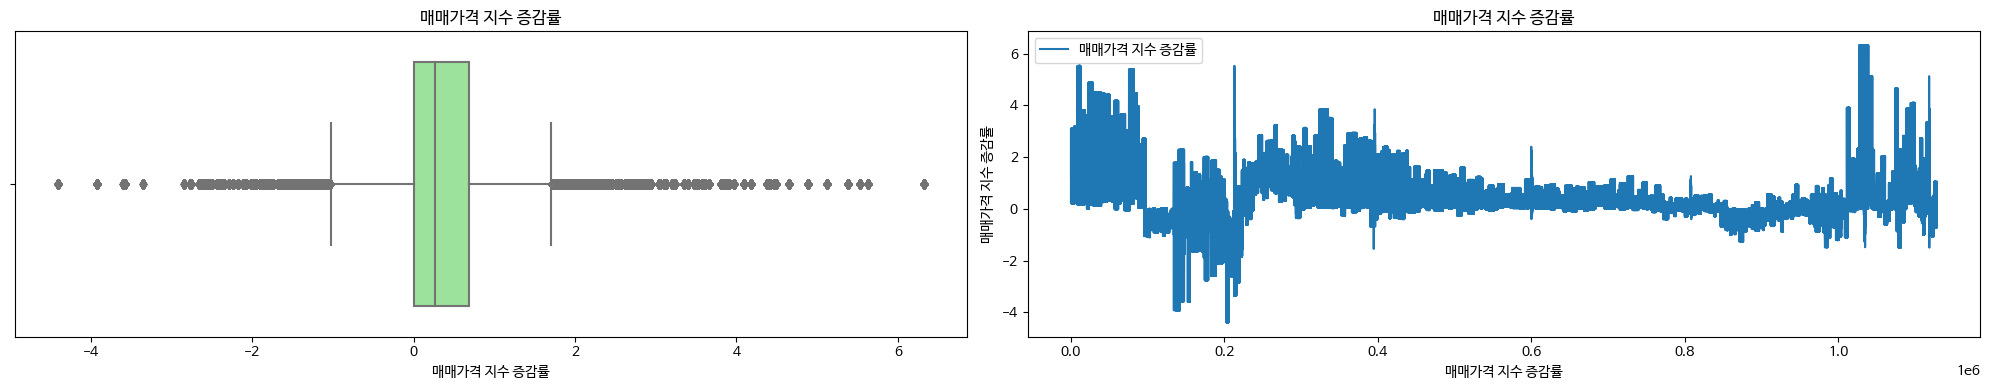

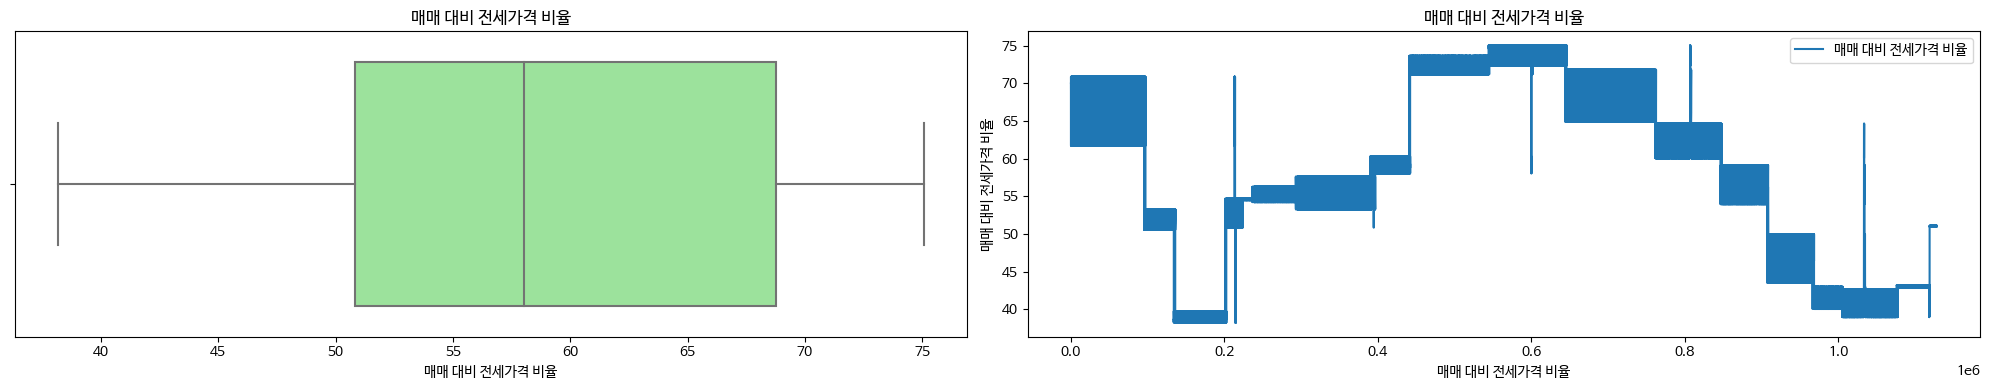

In [34]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
arr = ['전용면적_로그','전용면적', '계약년월', '계약일', '층', '건축년도','가장 가까운 거리', '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리', 
        '인근 버스 정류장 개수', 'GDP', '한국은행 기준금리', '기대 인플레이션', '지가지수', '미분양', '거래량',
       '건설사 랭킹',  '구별 지가지수', '공시지가 평균', '매수우위지수', '건물나이', '구매력지수',
       '거래활발지수', '매매가격 지수 증감률', '매매 대비 전세가격 비율',]


for i in arr:
    fig, ax = plt.subplots(1,2,figsize=(20, 4))

    sns.boxplot(data = df, x = i, ax=ax[0], color='lightgreen')
    ax[0].set_title(i)
    ax[0].set_xlabel(i)
  
    sns.lineplot(data=df[i], ax=ax[1], label= i)
    ax[1].set_title(i)
    ax[1].set_xlabel(i)
    # plt.ylabel('Open Price')
    # ax[1].set_xticks(rotation=45)

    plt.tight_layout()
    plt.show()


    


# def remove_outliers_iqr(dt, column_name):
#     df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
#     df_test = dt.query('is_test == 1')

#     Q1 = df[column_name].quantile(0.25)
#     Q3 = df[column_name].quantile(0.75)
#     IQR = Q3 - Q1

#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

#     result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    # return result

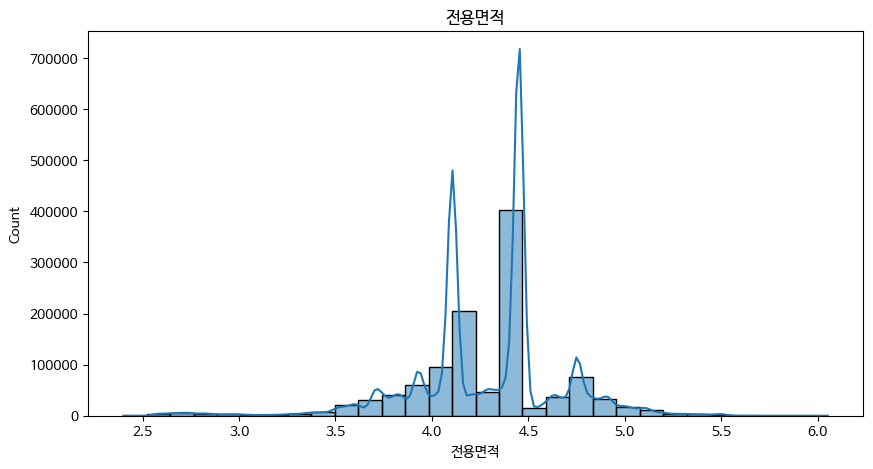

In [25]:
plt.figure(figsize=(10,5))
sns.histplot(np.log1p(df['전용면적']), bins=30, kde=True)
plt.title('전용면적')
plt.xlabel('전용면적')
plt.show()

/opt/conda/envs/upstage/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/envs/upstage/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/envs/upstage/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/envs/upstage/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/envs/

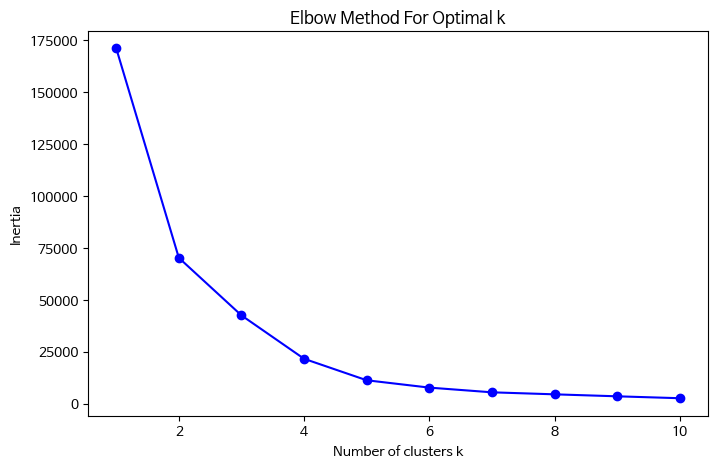

In [40]:
from sklearn.cluster import KMeans

# List to store the inertia values for different k
inertia = []

# Range of k values to try
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df[['전용면적_로그']])
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

/opt/conda/envs/upstage/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


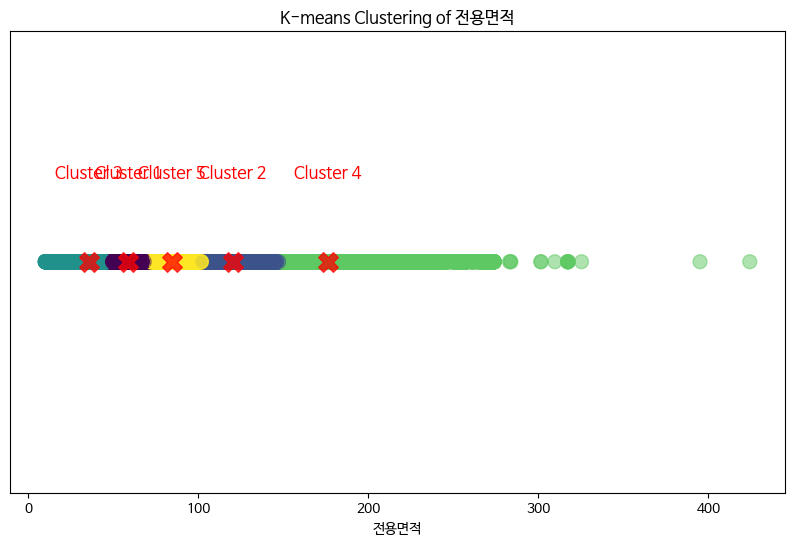

In [164]:
kmeans = KMeans(n_clusters=5, random_state=0)
df['전용면적_kmeans'] = kmeans.fit_predict(df[['전용면적']])


# Plotting the results
plt.figure(figsize=(10, 6))

# Scatter plot of the data points
plt.scatter(df['전용면적'], np.zeros_like(df['전용면적']), c=kmeans.labels_, cmap='viridis', s=100, alpha=0.5)

# Plotting the cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers, np.zeros_like(centers), c='red', s=200, alpha=0.75, marker='X')

# Adding titles and labels
plt.title('K-means Clustering of 전용면적')
plt.xlabel('전용면적')
plt.yticks([])  # Removing y-axis labels as they are not needed for a 1D plot

# Displaying the cluster labels
for i, center in enumerate(centers):
    plt.text(center, 0.02, f'Cluster {i+1}', fontsize=12, ha='center', color='red')

plt.show()

In [122]:
df['전용면적_로그'] = np.log1p(df['전용면적'])

In [205]:
# 계약월 변수 생성

df['계약월'] = df['계약년월'].astype(str).str[4:].astype(int)

In [206]:
# 계약년월, 계약일, 건축년도, 계약년 변수 제거

df.drop(['계약년월', '계약일'], axis=1, inplace=True)

In [207]:
df['계약월_sin'] = np.sin(2 * np.pi * df['계약월'] / 12)

In [173]:
df.columns

Index(['층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test', '가장 가까운 거리', '호선',
       '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', '계약년', '계약월', 'GDP',
       '한국은행 기준금리', '기대 인플레이션', '지가지수', '아파트 인허가', '미분양', '거래량', '건설사 랭킹', '구',
       '구별 지가지수', '공시지가 평균', '매수우위지수', '건물나이', '30년이상50년이하', '구매력지수', '거래활발지수',
       '매매가격 지수 증감률', '매매 대비 전세가격 비율', '아파트 카테고리', '지하철 카테고리', '전용면적_kmeans',
       '계약월_sin'],
      dtype='object')

In [69]:
# def add_distance_onehot(df):
#     df['subway_500m'] = (df['가장 가까운 거리'] <= 500).astype(int)
#     df['subway_1km'] = ((df['가장 가까운 거리'] > 500) & (df['가장 가까운 거리'] <= 1000)).astype(int)
#     df['subway_1.5km'] = ((df['가장 가까운 거리'] > 1000) & (df['가장 가까운 거리'] <= 1500)).astype(int)
#     return df

# # 원핫 인코딩 추가
# df = add_distance_onehot(df)

# def add_distance_onehot(df):
#     df['bus_500m'] = (df['가장 가까운 버스 정류장 거리'] <= 500).astype(int)
#     df['bus_1km'] = ((df['가장 가까운 버스 정류장 거리'] > 500) & (df['가장 가까운 버스 정류장 거리'] <= 1000)).astype(int)
#     df['bus_1.5km'] = ((df['가장 가까운 버스 정류장 거리'] > 1000) & (df['가장 가까운 버스 정류장 거리'] <= 1500)).astype(int)
#     return df

# # 원핫 인코딩 추가
# df = add_distance_onehot(df)

# scaling

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128094 entries, 0 to 1128093
Data columns (total 25 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   전용면적              1128094 non-null  float64
 1   층                 1128094 non-null  float64
 2   건축년도              1128094 non-null  float64
 3   좌표X               1128094 non-null  float64
 4   좌표Y               1128094 non-null  float64
 5   target            1118822 non-null  float64
 6   is_test           1128094 non-null  int64  
 7   가장 가까운 거리         1128094 non-null  float64
 8   호선                1128094 non-null  object 
 9   인근 지하철 역 개수       1128094 non-null  float64
 10  가장 가까운 버스 정류장 거리  1128094 non-null  float64
 11  인근 버스 정류장 개수      1128094 non-null  float64
 12  계약년               1128094 non-null  float64
 13  GDP               1128094 non-null  float64
 14  한국은행 기준금리         1128094 non-null  float64
 15  기대 인플레이션          1128094 non-null  float64
 16  

In [209]:
def scailing(col, scaler_type):
    if scaler_type == 'min_max': scaler = MinMaxScaler()
    else : scaler = StandardScaler()

    return scaler.fit_transform(df[[col]])

cols = ['전용면적', '층', '건축년도', '좌표X', '좌표Y', '가장 가까운 거리',
       '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', '계약년', 'GDP',
       '한국은행 기준금리', '기대 인플레이션', '지가지수', '아파트 인허가', '미분양', '거래량',
       '구별 지가지수', '공시지가 평균', '매수우위지수', '건물나이', '구매력지수', '거래활발지수',
       '매매가격 지수 증감률', '매매 대비 전세가격 비율',
       '계약월_sin']

for col in cols:
    print(col)
    scaler_type = 'min_max'
    if col == ['계약월_sin']: scaler_type = 'standard'

    df[[col]] = scailing(col, scaler_type)

전용면적
층
건축년도


좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
계약월_sin


# 호선 one-hot encoding

In [210]:
ohe = OneHotEncoder(sparse=False)
ohe_re = ohe.fit_transform(df[['호선']])

/opt/conda/envs/upstage/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [211]:
df = pd.concat([df, pd.DataFrame(ohe_re, columns=[col for col in ohe.categories_[0]])], axis=1)

In [212]:
ohe = OneHotEncoder(sparse=False)
ohe_re = ohe.fit_transform(df[['구']])
df = pd.concat([df, pd.DataFrame(ohe_re, columns=[col for col in ohe.categories_[0]])], axis=1)

/opt/conda/envs/upstage/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [213]:
df.drop(['호선'], axis=1, inplace=True)

In [214]:
df.drop(['구'], axis=1, inplace=True)

In [215]:
df.drop(['9호선(연장)', '경부선', '경의중앙선', '신분당선',
         '신림선', '신분당선(연장2)', '중앙선', '8호선',
         '우이신설선', '공항철도1호선', '경인선',
         '1호선','일산선', '과천선', '경춘선'], axis=1, inplace=True)

In [216]:
df.drop(['강남구',
       '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구', '동대문구',
       '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구', '용산구',
       '은평구', '종로구', '중구', '중랑구'], axis=1, inplace=True)

In [217]:
df.drop(['아파트 카테고리','지하철 카테고리'], axis=1, inplace=True)

# 카테고리 변수 처리
- 30년이상50년이하
- 아파트 카테고리
- 지하철 카테고리
- 구 카테고리
- 건설사 카테고리
- 인근 다리 개수 1개이상 3개 이하
- 학군

In [79]:
df.tail()

,전용면적,층,건축년도,좌표X,좌표Y,target,is_test,가장 가까운 거리,인근 지하철 역 개수,가장 가까운 버스 정류장 거리,...,7호선,9호선,경원선,분당선,subway_500m,subway_1km,subway_1.5km,bus_500m,bus_1km,bus_1.5km
1128089,0.180135,0.232877,0.854839,0.807949,0.728162,NaN,1,0.227756,0.173913,0.097533,...,0.0,0.0,0.0,0.0,0,1,0,1,0,0
1128090,0.180063,0.219178,0.854839,0.807949,0.728162,NaN,1,0.227756,0.173913,0.097533,...,0.0,0.0,0.0,0.0,0,1,0,1,0,0
1128091,0.221168,0.219178,0.854839,0.807949,0.728162,NaN,1,0.227756,0.173913,0.097533,...,0.0,0.0,0.0,0.0,0,1,0,1,0,0
1128092,0.180835,0.301370,0.854839,0.807949,0.728162,NaN,1,0.227756,0.173913,0.097533,...,0.0,0.0,0.0,0.0,0,1,0,1,0,0
1128093,0.180135,0.232877,0.854839,0.807949,0.728162,NaN,1,0.227756,0.173913,0.097533,...,0.0,0.0,0.0,0.0,0,1,0,1,0,0


In [75]:
df.columns

Index(['전용면적', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test', '가장 가까운 거리',
       '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', '계약년', 'GDP',
       '한국은행 기준금리', '기대 인플레이션', '지가지수', '아파트 인허가', '미분양', '거래량', '건설사 랭킹',
       '구별 지가지수', '공시지가 평균', '매수우위지수', '건물나이', '30년이상50년이하', '구매력지수', '거래활발지수',
       '매매가격 지수 증감률', '매매 대비 전세가격 비율', '아파트 카테고리', '지하철 카테고리', '구 카테고리',
       '건설사 카테고리', '가장 가까운 다리와의 거리', '인근 한강다리 개수', '인근 다리 개수 1개이상 3개 이하', '학군',
       '계약월_sin'],
      dtype='object')

In [76]:
df['30년이상50년이하'] = df['30년이상50년이하'].astype('category')
df['아파트 카테고리'] = df['아파트 카테고리'].astype('category')
df['지하철 카테고리'] = df['지하철 카테고리'].astype('category')
df['구 카테고리'] = df['구 카테고리'].astype('category')
df['건설사 카테고리'] = df['건설사 카테고리'].astype('category')
df['인근 다리 개수 1개이상 3개 이하'] = df['인근 다리 개수 1개이상 3개 이하'].astype('category')
df['학군'] = df['학군'].astype('category')

In [85]:
df.isnull().sum()

전용면적                   0
층                      0
건축년도                   0
좌표X                    0
좌표Y                    0
target              9272
is_test                0
가장 가까운 거리              0
인근 지하철 역 개수            0
가장 가까운 버스 정류장 거리       0
인근 버스 정류장 개수           0
계약년                    0
GDP                    0
한국은행 기준금리              0
기대 인플레이션               0
지가지수                   0
아파트 인허가                0
미분양                    0
거래량                    0
건설사 랭킹                 0
구별 지가지수                0
공시지가 평균                0
매수우위지수                 0
건물나이                   0
30년이상50년이하             0
계약월_sin                0
season                 0
2호선                    0
3호선                    0
4호선                    0
5호선                    0
6호선                    0
7호선                    0
9호선                    0
경원선                    0
분당선                    0
subway_500m            0
subway_1km             0
subway_1.5km           0
bus_500m               0


# Dataset 생성

## train, test 분할

In [218]:
# 추가한 feature들 중 일부 제거
df_dropped = df.drop([], axis=1)

In [183]:
df_dropped.columns

Index(['층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test', '가장 가까운 거리',
       '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', '계약년', '계약월', 'GDP',
       '한국은행 기준금리', '기대 인플레이션', '지가지수', '아파트 인허가', '미분양', '거래량', '건설사 랭킹',
       '구별 지가지수', '공시지가 평균', '매수우위지수', '건물나이', '30년이상50년이하', '구매력지수', '거래활발지수',
       '매매가격 지수 증감률', '매매 대비 전세가격 비율', '전용면적_kmeans', '계약월_sin', '2호선', '3호선',
       '4호선', '5호선', '6호선', '7호선', '9호선', '경원선', '분당선'],
      dtype='object')

In [219]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
kf = StratifiedKFold(n_splits=5)

In [220]:
train_df = df_dropped[df_dropped['is_test'] == 0]
test_df = df_dropped[df_dropped['is_test'] == 1]

In [221]:
train_df.drop(['is_test'], axis = 1, inplace=True)
test_df.drop(['is_test'], axis = 1, inplace=True)

/tmp/ipykernel_559971/3351882249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(['is_test'], axis = 1, inplace=True)
/tmp/ipykernel_559971/3351882249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(['is_test'], axis = 1, inplace=True)


In [105]:
print(train_df.shape)
print(test_df.shape)

(1118822, 39)
(9272, 39)


In [222]:
train_y = train_df[['target']]
train_X = train_df.drop(['target'], axis=1)

In [223]:
train_y = train_y.squeeze()

In [224]:
# 분할된 데이터를 fold별로 시각화하기 위한 함수를 구성합니다.
# Scikit-learn에서 https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html 사용한 코드를 가져와서 사용하겠습니다.
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(x, y, cv, ax, split_strategy='KFold', group=None, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    for ii, (tr, tt) in enumerate(cv.split(X=x, y=y, groups=group)):
        # Fill in indices with the training/test groups
        print(f"Fold {ii} :")
        print(f"  Train : index={tr[:5]}...")
        print(f"  Valid : index={tt[:5]}...")
        indices = np.array([np.nan] * len(x))
        indices[tt] = 1
        indices[tr] = 0
        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=0.2,
        )

    # Formatting
    yticklabels = list(range(5))

    ax.set(
        yticks=np.arange(len(yticklabels)) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[len(yticklabels) + 0.2, -0.2],
        xlim=[0, len(x)],
    )
    ax.set_title(split_strategy, fontsize=15)
    return ax

/opt/conda/envs/upstage/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 0 :
  Train : index=[57348 57892 57907 87277 87288]...
  Valid : index=[0 1 2 3 4]...
Fold 1 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[57348 57892 57907 87277 87288]...
Fold 2 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[ 87353  87359  87362 197758 203308]...
Fold 3 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[ 87289  87354  87361 212662 212727]...
Fold 4 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[ 87294 212733 223819 223914 224567]...


<Axes: title={'center': 'Stratified K-Fold'}, xlabel='Sample index', ylabel='CV iteration'>

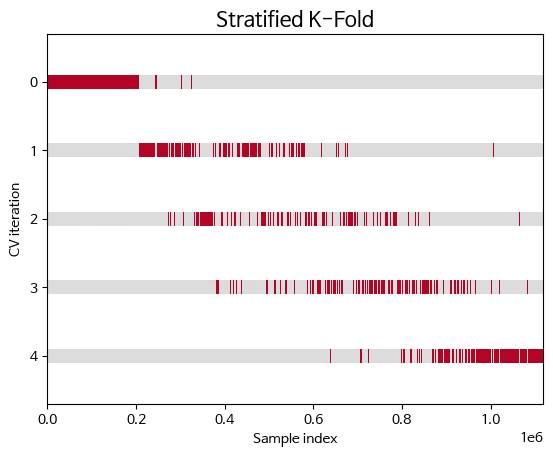

In [225]:
cut_Y_train = pd.cut(train_y,
                     1000, # 데이터를 최소 최대 구간으로 1000등분 합니다.
                     labels=False)
fig, ax = plt.subplots()
plot_cv_indices(x=train_X,
                y=cut_Y_train,
                cv=kf,
                ax=ax,
                split_strategy='Stratified K-Fold')

/opt/conda/envs/upstage/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


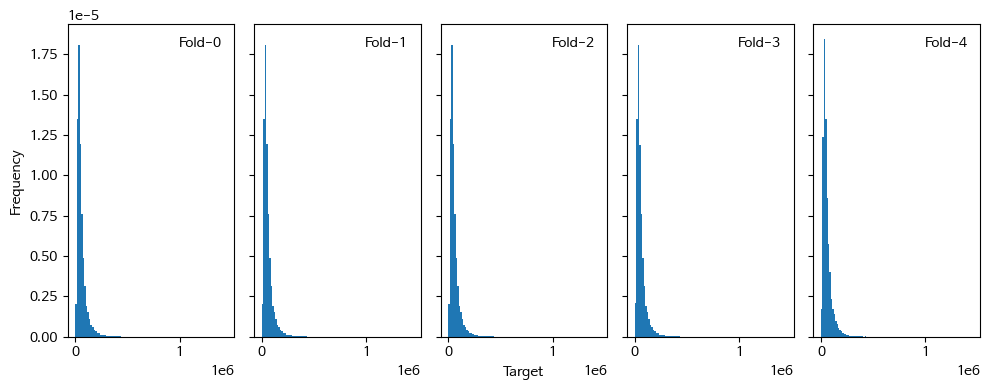

In [191]:
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(10,4)) # 5개의 plot을 만듭니다.
for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(train_X, cut_Y_train)): # fold별로 iteration을 만듭니다.
    axs[fold_idx].hist(train_y[train_idx], bins=100, density=True, label=f'Fold-{fold_idx}') # 각 fold에 해당하는 Target값을 가져옵니다.
    if fold_idx == 0:
        axs[fold_idx].set_ylabel('Frequency')
    if fold_idx == 2:
        axs[fold_idx].set_xlabel("Target")
    axs[fold_idx].legend(frameon=False, handlelength=0)
plt.tight_layout()
plt.show()

In [192]:
train_X.columns

Index(['층', '건축년도', '좌표X', '좌표Y', '가장 가까운 거리', '인근 지하철 역 개수',
       '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', '계약년', '계약월', 'GDP', '한국은행 기준금리',
       '기대 인플레이션', '지가지수', '아파트 인허가', '미분양', '거래량', '건설사 랭킹', '구별 지가지수',
       '공시지가 평균', '매수우위지수', '건물나이', '30년이상50년이하', '구매력지수', '거래활발지수',
       '매매가격 지수 증감률', '매매 대비 전세가격 비율', '전용면적_kmeans', '계약월_sin', '2호선', '3호선',
       '4호선', '5호선', '6호선', '7호선', '9호선', '경원선', '분당선'],
      dtype='object')

## train, valid 분할

In [226]:
train_folds = kf.split(train_X, cut_Y_train)
display(train_folds)

<generator object _BaseKFold.split at 0x7fb8f4deb0d0>

In [ ]:
%%time
fold_save_files = []

params = {
    'n_estimators': 100000,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'metric_freq': 20,
    'device': 'gpu',
    'verbosity': 0
}


for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    print(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = train_X.iloc[train_idx, :]
    Y_train_fold = train_y[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = train_X.iloc[valid_idx, :]
    Y_valid_fold = train_y[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    model = lgb.LGBMRegressor(n_estimators=100000,
                          metric='rmse', data_sample_strategy='goss'
                          )

    model.fit(X_train_fold, Y_train_fold, # 학습 데이터를 입력합니다.
        eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)], # 평가셋을 지정합니다.
        eval_metric ='rmse', # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[lgb.early_stopping(stopping_rounds=10), # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)] # 매 iteration마다 학습결과를 출력합니다.
    )


    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"Stratified_kfold{fold_idx}_gbm.pkl"
    joblib.dump(model, file_name)
    display(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)

In [237]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# LightGBM parameters
lgb_params = {
    'n_estimators': 100000,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'metric_freq': 20,
    'device': 'gpu',
    'verbosity': 0
}

# XGBoost parameters
xgb_params = {
    'n_estimators': 100000,
    'learning_rate': 0.05,
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist',
    'verbosity': 1
}

# To store the models for stacking
base_models = []
fold_save_files = []

# Stacking Regressor
stacking_model = StackingRegressor(estimators=[], final_estimator=LinearRegression())

# K-Fold Cross-Validation Loop
for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(train_X, train_y)):
    print(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = train_X.iloc[train_idx, :]
    Y_train_fold = train_y.iloc[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = train_X.iloc[valid_idx, :]
    Y_valid_fold = train_y.iloc[valid_idx]

    # XGBoost 모델 학습z
    xgb_model = xgb.XGBRegressor(n_estimators=100000,
                          metric='rmse', data_sample_strategy='goss')
    xgb_model.fit(X_train_fold, Y_train_fold, 
                  eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)],
        
                  eval_metric='rmse',
                  early_stopping_rounds=10, 
                  verbose=10)


    # LightGBM 모델 학습

    lgb_model = lgb.LGBMRegressor(n_estimators=100000,
                          metric='rmse', data_sample_strategy='goss'
                          )
    lgb_model.fit(X_train_fold, Y_train_fold, # 학습 데이터를 입력합니다.
        eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)], # 평가셋을 지정합니다.
        eval_metric ='rmse', # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[lgb.early_stopping(stopping_rounds=10), # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)] # 매 iteration마다 학습결과를 출력합니다.
    )
    
    

    
    # 각 fold별 학습한 모델을 저장합니다.
    lgb_file_name = f"Fold{fold_idx}_lgb.pkl"
    xgb_file_name = f"Fold{fold_idx}_xgb.pkl"

    joblib.dump(lgb_model, lgb_file_name)
    joblib.dump(xgb_model, xgb_file_name)

    print(f"--------{fold_idx}번째 fold는 {lgb_file_name}과 {xgb_file_name}에 저장되었습니다.--------\n\n")

    fold_save_files.append((lgb_file_name, xgb_file_name))
    base_models.extend([(f'lgb_fold_{fold_idx}', lgb_model), (f'xgb_fold_{fold_idx}', xgb_model)])

    stacking_model.final_estimator_ = LinearRegression()
    stacking_model.fit(train_X, train_y)

# Stacking model 예측
test_df.drop(['target'], axis=1, inplace=True)
stacking_predictions = stacking_model.predict(test_df)

--------0번째 fold의 학습을 시작합니다.--------


TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [195]:
root = '/root/home_predict/code/'
top_3_files = [f"{root}Stratified_kfold0_gbm.pkl",f"{root}Stratified_kfold1_gbm.pkl", f"{root}Stratified_kfold2_gbm.pkl", f"{root}Stratified_kfold3_gbm.pkl",f"{root}Stratified_kfold4_gbm.pkl"]
# total_predicts = np.zeros(len(X_test))

test_df.drop(['target'], axis=1, inplace=True)
fold_predictions = []

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    predictions = gbm_trained.predict(test_df)
    fold_predictions.append(predictions)

final_predictions = np.mean(fold_predictions, axis=0)    

/tmp/ipykernel_559971/289668223.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(['target'], axis=1, inplace=True)


In [114]:
# train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, train_size=0.95, test_size=0.05, random_state=74)

# print(train_X.shape, train_y.shape)
# print(valid_X.shape, valid_y.shape)

(1062880, 40) (1062880, 1)
(55942, 40) (55942, 1)


In [113]:
train_X.columns

Index(['전용면적', '층', '건축년도', '좌표X', '좌표Y', '가장 가까운 거리', '인근 지하철 역 개수',
       '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', '계약년', '계약월', 'GDP', '한국은행 기준금리',
       '기대 인플레이션', '지가지수', '아파트 인허가', '미분양', '거래량', '건설사 랭킹', '구별 지가지수',
       '공시지가 평균', '매수우위지수', '건물나이', '30년이상50년이하', '구매력지수', '거래활발지수',
       '매매가격 지수 증감률', '매매 대비 전세가격 비율', '계약월_sin', '2호선', '3호선', '4호선', '5호선',
       '6호선', '7호선', '9호선', '경원선', '분당선'],
      dtype='object')

# model

In [115]:
params = {
    'n_estimators': 100000,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'metric_freq': 20,
    'device': 'gpu',
    'verbosity': 0
}

model = lgb.LGBMRegressor(n_estimators=100000,
                          metric='rmse', data_sample_strategy='goss'
                          )

model.fit(
    train_X, train_y,
    eval_set = [(train_X, train_y), (valid_X, valid_y)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=60),
               lgb.log_evaluation(period=10, show_stdv=True)]
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2924
[LightGBM] [Info] Number of data points in the train set: 1062880, number of used features: 39
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 57982.908459
Training until validation scores don't improve for 60 rounds
[10]	training's rmse: 26462.5	valid_1's rmse: 27022.9
[20]	training's rmse: 19799.6	valid_1's rmse: 20192.6
[30]	training's rmse: 16783.2	valid_1's rmse: 17109.1
[40]	training's rmse: 15076.2	valid_1's rmse: 15401.4
[50]	training's rmse: 14127.1	valid_1's rmse: 14463.3
[60]	training's rmse: 13473.5	valid_1's rmse: 13815.3
[70]	training'

LGBMRegressor(data_sample_strategy='goss', metric='rmse', n_estimators=100000)

In [116]:
joblib.dump(model, '../feature_test.pkl')

['../feature_test.pkl']

In [117]:
train_X.columns

Index(['전용면적', '층', '건축년도', '좌표X', '좌표Y', '가장 가까운 거리', '인근 지하철 역 개수',
       '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', '계약년', 'GDP', '한국은행 기준금리',
       '기대 인플레이션', '지가지수', '아파트 인허가', '미분양', '거래량', '건설사 랭킹', '구별 지가지수',
       '공시지가 평균', '매수우위지수', '건물나이', '30년이상50년이하', '계약월_sin', 'season', '2호선',
       '3호선', '4호선', '5호선', '6호선', '7호선', '9호선', '경원선', '분당선', 'subway_500m',
       'subway_1km', 'subway_1.5km', 'bus_500m', 'bus_1km', 'bus_1.5km'],
      dtype='object')

In [198]:
pd.set_option('display.max_columns', None)
train_X.head()

,전용면적,층,건축년도,좌표X,좌표Y,가장 가까운 거리,인근 지하철 역 개수,가장 가까운 버스 정류장 거리,인근 버스 정류장 개수,계약년,GDP,한국은행 기준금리,기대 인플레이션,지가지수,아파트 인허가,미분양,거래량,건설사 랭킹,구별 지가지수,공시지가 평균,매수우위지수,건물나이,30년이상50년이하,계약월_sin,season,2호선,3호선,4호선,5호선,6호선,7호선,9호선,경원선,분당선
0,0.168839,0.095890,0.419355,0.678243,0.167126,0.353721,0.086957,0.101599,0.2,0.6250,0.776663,0.210526,0.290323,0.408809,1.000000,0.004182,0.466276,2.0,0.395747,0.509398,0.513427,0.561644,1,-0.022272,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.168839,0.109589,0.419355,0.678243,0.167126,0.353721,0.086957,0.101599,0.2,0.6250,0.776663,0.210526,0.290323,0.408809,1.000000,0.004182,0.466276,2.0,0.395747,0.509398,0.513427,0.561644,1,-0.022272,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.108520,0.123288,0.419355,0.678243,0.167126,0.353721,0.086957,0.101599,0.2,0.6250,0.776663,0.210526,0.290323,0.408809,1.000000,0.004182,0.466276,2.0,0.395747,0.509398,0.513427,0.561644,1,-0.022272,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.168839,0.109589,0.419355,0.678243,0.167126,0.353721,0.086957,0.101599,0.2,0.6875,0.893613,0.210526,0.322581,0.418392,0.205671,0.004182,0.522738,2.0,0.403844,0.551484,0.702685,0.575342,1,0.684200,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.168839,0.082192,0.419355,0.678243,0.167126,0.353721,0.086957,0.101599,0.2,0.6875,0.893613,0.210526,0.322581,0.418392,0.205671,0.004182,0.522738,2.0,0.403844,0.551484,0.702685,0.575342,1,0.684200,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


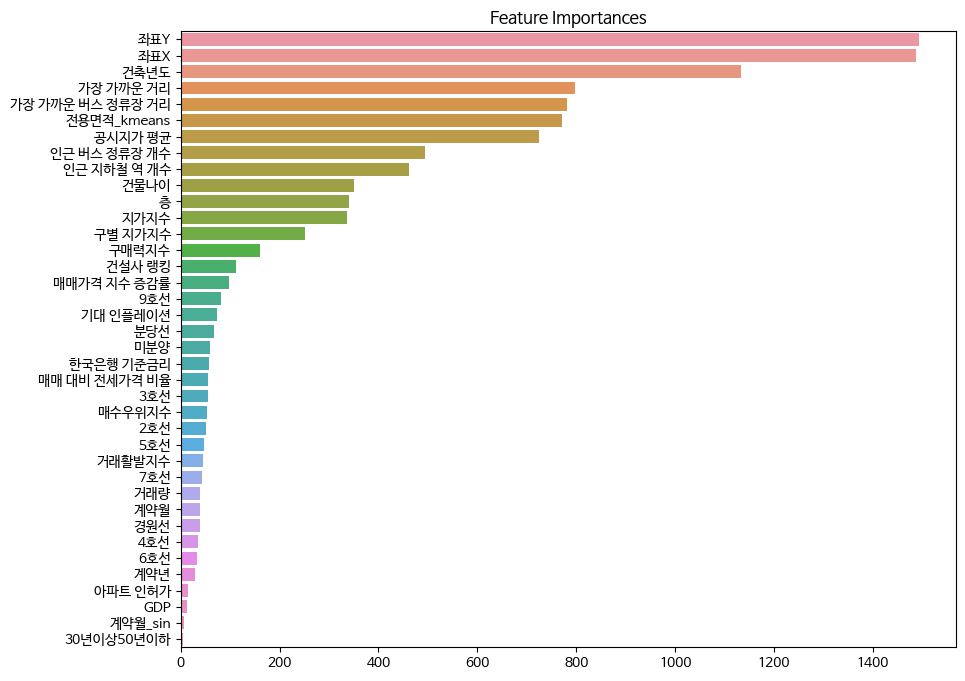

In [196]:
importances = pd.Series(model.feature_importances_, index=list(train_X.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

# submission

In [ ]:
test_df.drop(['target'], axis=1, inplace=True)

### 예측

In [121]:
preds = model.predict(test_df)

# 결과값 처리
- float 형태에서 int 형태로 변환 (반올림 사용)
- 결과 순서를 맞춰줘야 된다. -> 기존 test 데이터에 target column을 추가하고 거기에 결과를 저장한다.
- 모든 결과를 concat하고 인덱스를 기준으로 정렬한다.

In [197]:
preds = np.round(final_predictions).astype(int)

In [198]:
preds_df = pd.DataFrame(preds, columns=['target'])

In [ ]:
preds_df

In [199]:
preds_df.to_csv('../pred.csv', index=False)